### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 7


### Дисциплина: Методы машинного обучения

##### Студент:  Матюшкин Денис Владимирович
##### Группа:   НПИбд-02-21

## Москва 2024
***

### Вариант № 14

Текст задания:
1. Набор данных: imagenette/160px-v2 с изменением разрешения до 32х32

2. Диапазон классов: 4, 5, 6, 7

3. Архитектура автокодировщика: CNN

4. Показатель качества: cреднее абсолютное процентное отклонение (MAPE) для ошибки реконструкции

5. Показатель качества бинарной классификации: специфичность, равная TN/(TN+FP)

### Решение:

1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки. Оставьте в обучающей и тестовой выборках диапазон классов, указанных в индивидуальном задании. Если изображения цветные (с тремя каналами), то перекодируйте их в одноцветные (оттенки серого).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [51]:
ds = tfds.load("imagenette/160px-v2", split=['train', 'validation'])

In [52]:
df_train = tfds.as_dataframe(ds[0])
df_test = tfds.as_dataframe(ds[1])

df_train.shape, df_test.shape

((9469, 2), (3925, 2))

In [4]:
df_train.head()

,image,label
0,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",2
1,"[[[99, 97, 98], [171, 169, 170], [220, 218, 21...",6
2,"[[[2, 6, 18], [5, 9, 20], [5, 12, 22], [6, 13,...",7
3,"[[[172, 167, 101], [180, 174, 112], [193, 188,...",3
4,"[[[0, 2, 5], [26, 31, 34], [23, 28, 31], [6, 1...",4


In [53]:
df_train = df_train.loc[df_train['label'].isin([4, 5, 6, 7])]
df_test = df_test.loc[df_test['label'].isin([4, 5, 6, 7])]

df_train['label'] = df_train['label'].map({4:0, 5:1, 6:2, 7:3})
df_test['label'] = df_test['label'].map({4:0, 5:1, 6:2, 7:3})

df_train.shape, df_test.shape

((3789, 2), (1611, 2))

In [54]:
df_train['label'].unique(), df_test['label'].unique()

(array([2, 3, 0, 1]), array([3, 2, 1, 0]))

In [55]:
df_train.iloc[0]['image'].shape

(160, 213, 3)

In [56]:
def resize_image(image, size=(32, 32)):
    image = Image.fromarray(image)
    image = image.resize(size, Image.ANTIALIAS)
    return np.array(image)

In [57]:
df_train['image'] = df_train['image'].apply(lambda x: resize_image(x, size=(32, 32)))
df_test['image'] = df_test['image'].apply(lambda x: resize_image(x, size=(32, 32)))

In [58]:
df_train.iloc[0]['image'].shape

(32, 32, 3)

In [59]:
def display_image(df_train):
  img = Image.fromarray(df_train.iloc[0]['image'])
  plt.imshow(img);

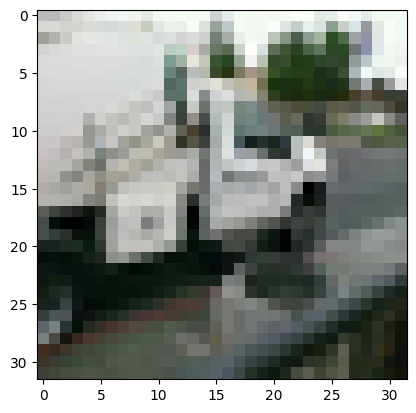

In [60]:
display_image(df_train)

In [61]:
def convert_gray(obj):
    return np.dot(obj[..., :3], [0.299, 0.587, 0.114])

In [62]:
df_train['image'] = df_train['image'].apply(lambda x: convert_gray(x.copy()))
df_test['image'] = df_test['image'].apply(lambda x: convert_gray(x.copy()))

(32, 32)

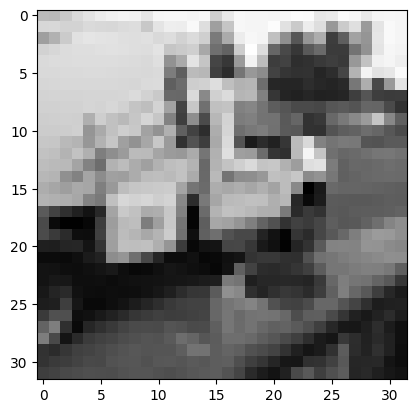

In [63]:
display_image(df_train)
df_train.iloc[0]['image'].shape

2. Постройте для набора данных график логарифмического правдоподобия профиля в зависимости от числа главных компонент и определите размерность латентного пространства.

In [64]:
x_train = np.array([image.flatten() for image in df_train['image']])

In [65]:
x_train.shape

(3789, 1024)

In [66]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

def log_likelihood(evals):

    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)

    for L in range(Lmax):

        group1 = evals[0 : L + 1]
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2

    return ll

In [67]:
X_rank = np.linalg.matrix_rank(x_train)
K_linspace = np.linspace(1, 0.75 * X_rank, 10, dtype=int)
Ks = np.unique(np.append([1, 5, 10, 20], K_linspace))

RMSE_train = np.arange(len(Ks))

for index, K in enumerate(Ks):
    pca = PCA(n_components=K)

    Xtrain_transformed = pca.fit_transform(x_train)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    RMSE_train[index] = mean_squared_error(x_train, Xtrain_proj, squared=False)

In [68]:
n_samples, n_features = x_train.shape
Kmax = min(n_samples, n_features)

pca = PCA(n_components=Kmax)
X_transformed = pca.fit_transform(x_train)
evals = pca.explained_variance_

ll = log_likelihood(evals)

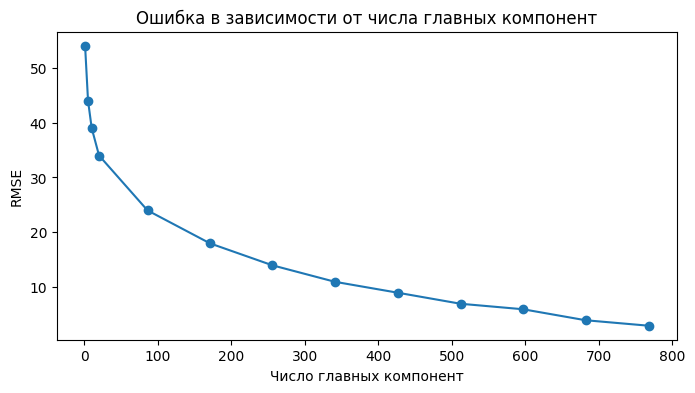

In [69]:
fig, ax = plt.subplots(figsize=(8, 4))
xs = Ks
ys = RMSE_train
plt.title("Ошибка в зависимости от числа главных компонент")
plt.xlabel("Число главных компонент")
plt.ylabel("RMSE")
ax.plot(xs, ys, marker="o")
plt.show()

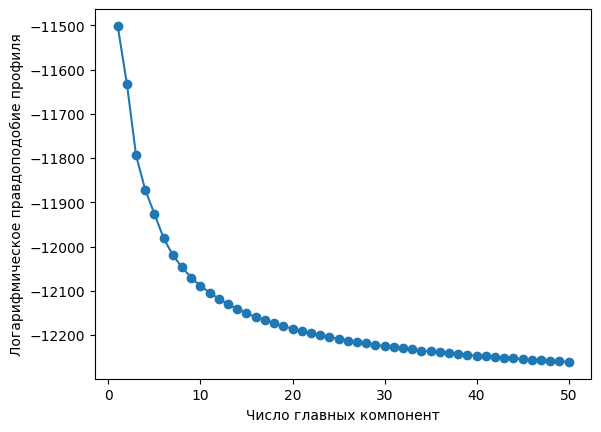

In [70]:
fig, ax = plt.subplots()
xs = np.arange(1, 51)
ys = ll[0:50]
plt.xlabel("Число главных компонент")
plt.ylabel("Логарифмическое правдоподобие профиля")

ax.plot(xs, ys, marker="o")
plt.show()

По графику видно, что размерность латентного пространства: 1. Поскольку он слишком маленький, при автокодировании зададим сами.

3. Создайте и обучите на обучающей выборке автокодировщик архитектуры, указанной в индивидуальном задании, с размерностью скрытого представления, равной размерности латентного пространства, определенной в п.2. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Визуализируйте несколько исходных и восстановленных автокодировщиком изображений.

In [71]:
train_labels = df_train['label'].to_numpy(dtype=np.float32)
test_labels = df_test['label'].to_numpy(dtype=np.float32)

train_labels.shape, test_labels.shape

((3789,), (1611,))

In [72]:
train_images = np.zeros(shape=(df_train.shape[0],32,32), dtype=np.float32)
test_images  = np.zeros(shape=(df_test.shape[0],32,32), dtype=np.float32)

train_images.shape, test_images.shape

((3789, 32, 32), (1611, 32, 32))

In [73]:
for idx in range(train_labels.shape[0]):
  train_images[idx,:,:] = np.array(Image.fromarray(df_train.iloc[idx]['image']).resize((32,32)))

for idx in range(test_labels.shape[0]):
  test_images[idx,:,:] = np.array(Image.fromarray(df_test.iloc[idx]['image']).resize((32,32)))


train_images.shape, test_images.shape

((3789, 32, 32), (1611, 32, 32))

In [74]:
train_images /= 255.0
test_images /= 255.0

In [75]:
train_images_CNN = train_images.reshape(
    (len(train_images), 32, 32, 1))
test_images_CNN  = test_images.reshape(
    (len(test_images), 32, 32, 1))

train_images_CNN.shape, test_images_CNN.shape

((3789, 32, 32, 1), (1611, 32, 32, 1))

In [28]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model

In [90]:
input_img = tf.keras.Input(shape=(32, 32, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoderCNN = Model(input_img, decoded)

Размерность латентного пространства данного CNN-автокодировщика составляет 128.

In [91]:
autoencoderCNN.compile(optimizer='adam', loss='binary_crossentropy')

autoencoderCNN.fit(train_images_CNN, train_images_CNN,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images_CNN, test_images_CNN),
                verbose = 1);

Epoch 1/10
15/15 [==============================] - 8s 442ms/step - loss: 0.6916 - val_loss: 0.6879
Epoch 2/10
15/15 [==============================] - 5s 312ms/step - loss: 0.6777 - val_loss: 0.6575
Epoch 3/10
15/15 [==============================] - 5s 310ms/step - loss: 0.6374 - val_loss: 0.6255
Epoch 4/10
15/15 [==============================] - 8s 502ms/step - loss: 0.6199 - val_loss: 0.6159
Epoch 5/10
15/15 [==============================] - 5s 315ms/step - loss: 0.6115 - val_loss: 0.6101
Epoch 6/10
15/15 [==============================] - 6s 392ms/step - loss: 0.6066 - val_loss: 0.6062
Epoch 7/10
15/15 [==============================] - 5s 340ms/step - loss: 0.6033 - val_loss: 0.6036
Epoch 8/10
15/15 [==============================] - 5s 308ms/step - loss: 0.6009 - val_loss: 0.6018
Epoch 9/10
15/15 [==============================] - 6s 430ms/step - loss: 0.5995 - val_loss: 0.6001
Epoch 10/10
15/15 [==============================] - 5s 317ms/step - loss: 0.5977 - val_loss: 0.5992

In [92]:
import matplotlib.pyplot as plt

def image_show(orig_imgs, dec_imgs, fname=None):
    n = 10  # кол-во изображений
    fig = plt.figure(figsize=(20, 4))
    for i in range(n):
        # исходные изображения
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig_imgs[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # реконструированные изображения
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(dec_imgs[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

    if fname:
        fig.savefig(fname)

In [93]:
decoded_imgs = autoencoderCNN.predict(test_images_CNN)

51/51 [==============================] - 2s 28ms/step


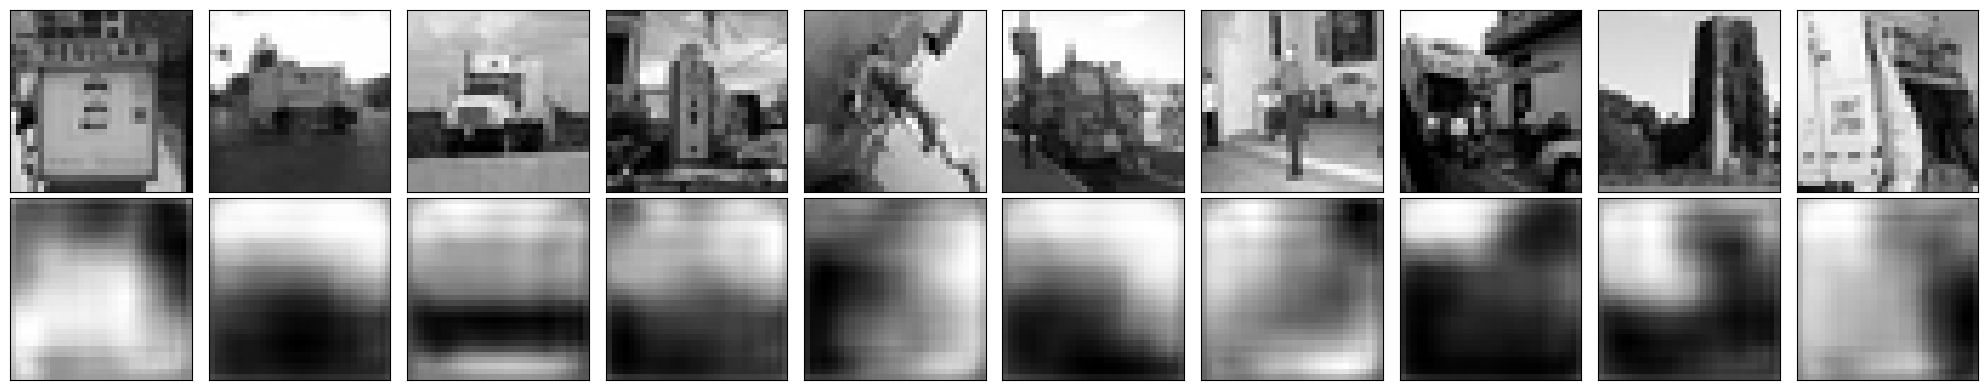

In [94]:
image_show(test_images_CNN, decoded_imgs)

4. Оцените качество модели автокодировщика на тестовой выборке по показателю, указанному в индивидуальном задании.

In [95]:
def calculate_mape(true_values, predicted_values):
    n = len(true_values)
    true_values = true_values + 1e-7
    absolute_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(absolute_percentage_errors) /n

    return mape

In [96]:
print(f"Оценка mape: {calculate_mape(test_images_CNN, decoded_imgs)}")

Оценка mape: 10.354049066961515


5. Оставьте в наборах изображения первых двух классов диапазона, указанного в индивидуальном задании первыми. Визуализируйте набор данных на плоскости, соответствующей двум первым латентным признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

In [97]:
df_train['label'].unique(), df_test['label'].unique()

(array([2, 3, 0, 1]), array([3, 2, 1, 0]))

In [98]:
df_binary_train = df_train.loc[df_train['label'].isin([0, 1])]
df_binary_test = df_test.loc[df_test['label'].isin([0, 1])]

df_binary_train.shape, df_binary_test.shape, \
df_binary_train['label'].unique(), df_binary_test['label'].unique()

((1897, 2), (803, 2), array([0, 1]), array([1, 0]))

In [99]:
train_binary_labels = df_binary_train['label'].to_numpy(dtype=np.float32)

train_binary_labels.shape

(1897,)

In [100]:
train_binary_images = np.zeros(shape=(df_binary_train.shape[0],32,32), dtype=np.float32)

for idx in range(train_binary_labels.shape[0]):
  train_binary_images[idx,:,:] = np.array(Image.fromarray(df_binary_train.iloc[idx]['image']).resize((32,32)))

train_binary_images /= 255.0

train_binary_images = train_binary_images.reshape(
    (len(train_binary_images), 32, 32, 1))

train_binary_images.shape

(1897, 32, 32, 1)

In [101]:
autoencoderCNN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 8)           584 

60/60 [==============================] - 1s 10ms/step


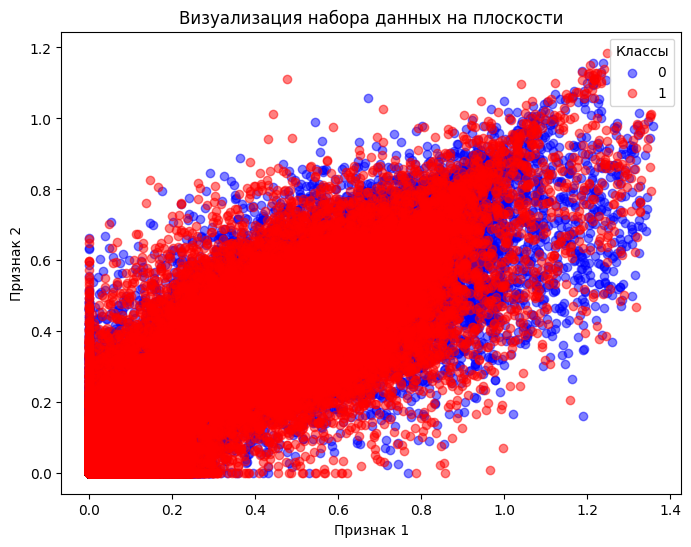

In [102]:
encoder = Model(inputs=autoencoderCNN.input, outputs=autoencoderCNN.get_layer('max_pooling2d_5').output)

latent_features = encoder.predict(train_binary_images)

plt.figure(figsize=(8, 6))
colors = ['b', 'r']
for label, color in zip(df_binary_train['label'].unique(), colors):
    plt.scatter(latent_features[df_binary_train['label'] == label, 0],
                latent_features[df_binary_train['label'] == label, 1],
                c=color, label=label, alpha=0.5)

plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Визуализация набора данных на плоскости')
plt.legend(title='Классы')
plt.show()

6. Выполните бинарную классификацию изображений по латентным (скрытым) признакам и всем признакам при помощи классификатора метода ближайших соседей (kNN). Оцените долю верных ответов (accuracy) для двух построенных классификаторов

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [104]:
X_latent = latent_features.reshape(len(latent_features), -1)
y_latent = train_binary_labels

X_all = train_binary_images.reshape(len(train_binary_images), -1)
y_all = train_binary_labels

X_latent_train, X_latent_test, y_latent_train, y_latent_test = train_test_split(X_latent, y_latent, test_size=0.2, random_state=42)
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [105]:
knn_latent = KNeighborsClassifier(n_neighbors=7)
knn_latent.fit(X_latent_train, y_latent_train)
y_latent_pred = knn_latent.predict(X_latent_test)

conf_matrix_latent = confusion_matrix(y_latent_test, y_latent_pred)
TN_latent = conf_matrix_latent[0, 0]
FP_latent = conf_matrix_latent[0, 1]

specificity_latent = TN_latent / (TN_latent + FP_latent)

In [106]:
knn_all = KNeighborsClassifier(n_neighbors=7)
knn_all.fit(X_all_train, y_all_train)
y_all_pred = knn_all.predict(X_all_test)

conf_matrix_all = confusion_matrix(y_all_test, y_all_pred)
TN_all = conf_matrix_all[0, 0]
FP_all = conf_matrix_all[0, 1]

specificity_all = TN_all / (TN_all + FP_all)

print("Специфичность с использованием скрытых функций:", specificity_latent)
print("Специфичность при использовании всех функций:", specificity_all)

Специфичность с использованием скрытых функций: 0.7471264367816092
Специфичность при использовании всех функций: 0.6896551724137931


7. Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) (Указание: используйте метод predict_proba() класса KNeighborsClassifier).

In [107]:
from sklearn.metrics import accuracy_score, roc_curve, auc

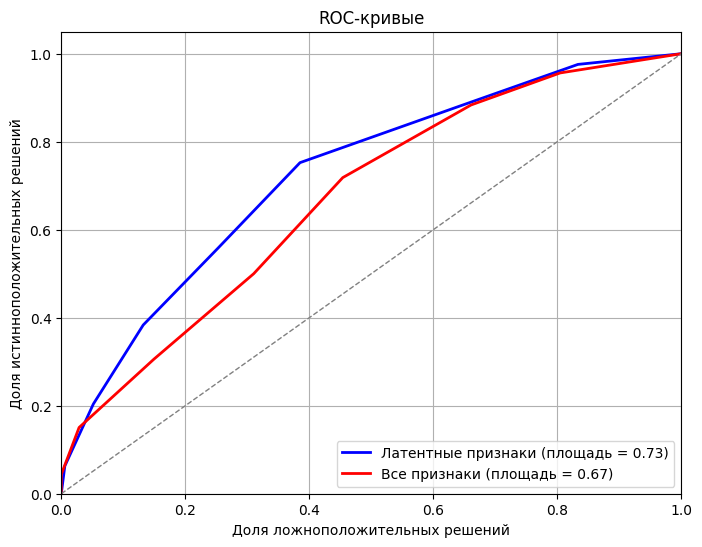

In [108]:
y_latent_proba = knn_latent.predict_proba(X_latent_test)
y_all_proba = knn_all.predict_proba(X_all_test)

y_latent_scores = y_latent_proba[:, 1]
y_all_scores = y_all_proba[:, 1]

fpr_latent, tpr_latent, _ = roc_curve(y_latent_test, y_latent_scores)
roc_auc_latent = auc(fpr_latent, tpr_latent)

fpr_all, tpr_all, _ = roc_curve(y_all_test, y_all_scores)
roc_auc_all = auc(fpr_all, tpr_all)

plt.figure(figsize=(8, 6))

plt.plot(fpr_latent, tpr_latent, color='blue', lw=2, label='Латентные признаки (площадь = %0.2f)' % roc_auc_latent)
plt.plot(fpr_all, tpr_all, color='red', lw=2, label='Все признаки (площадь = %0.2f)' % roc_auc_all)

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных решений')
plt.ylabel('Доля истинноположительных решений')
plt.title('ROC-кривые')
plt.legend(loc="lower right")
plt.grid()
plt.show()

8. Визуализируйте границы принятия решений классификатора kNN для латентных признаков на плоскости, соответствующей двум первым латентным признакам (для прочих латентных признаков задайте средние/медианные значения).

Не смог.

9. Определите на первоначальной тестовой выборке изображение, имеющее наибольшую ошибку реконструкции. Выведите для этого изображения первоначальное и реконструированное изображения.

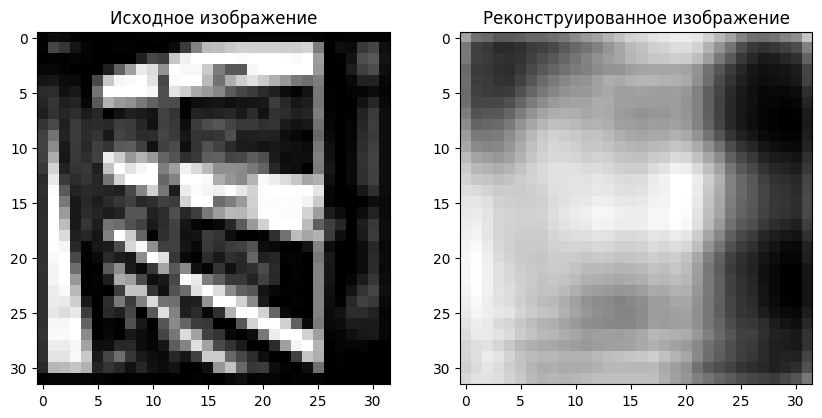

In [109]:
errors = [mean_squared_error(test_image.flatten(), decoded_image.flatten())
          for test_image, decoded_image in zip(test_images_CNN, decoded_imgs)]

max_error_index = np.argmax(errors)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_images_CNN[max_error_index])
plt.title('Исходное изображение')
plt.subplot(1, 2, 2)
plt.imshow(decoded_imgs[max_error_index])
plt.title('Реконструированное изображение')
plt.show()
